##### First we define the problem , Collect and Preprocess Data
##### Currect Notebook implements exactly this step
#####
##### We train model to recognise single fruit (Red Apple , whole unit), 
##### model is abridged version of VGG16, https://datagen.tech/guides/computer-vision/vgg16/
#####
##### After model is trained , we check accuracy over validation and test data
##### https://scikit-learn.org/stable/modules/model_evaluation.html
#####
##### Afterwards,  we apply R CNN approach: picture of choice is broken into multiple sub pics(proposals, rects)
#####  and we employ previously trained model to check if proposal contains apple
#####  https://www.geeksforgeeks.org/r-cnn-region-based-cnns/
#####  https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/Girshick_Fast_R-CNN_ICCV_2015_paper.pdf
#####
##### Current implementation does not require manual labelling

https://www.analyticsvidhya.com/blog/2022/02/blood-cell-detection-in-image-using-naive-approach/

In [25]:
# upload libraries to prepare data
import os
import numpy as np
import cv2

import matplotlib.pyplot as plt


In [2]:
## We preprocess data which forms both trainig and test pics,  later we would apply
## train_test_split method to generate 70 30 split, 

In [26]:
# set dimensions to resize each image, it provides consistent input for CNN
IMG_HEIGHT = 250
IMG_WIDTH = 250

# location of pictures for train, validation and testing
folder_train = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\1_Raw_Data_Train_Test"
folder_train

'D:\\0_Desctop_Files\\Learning\\UTM_Project\\1_Prototype\\1_Raw_Data_Train_Test'

In [27]:
os.listdir(folder_train) # debug

['apple_y_braeburn_1',
 'apple_y_crimson_snow_1',
 'apple_y_red_1',
 'apple_y_red_2',
 'apple_y_red_3',
 'apple_y_red_delicios_1',
 'apple_y_red_yellow_1',
 'cabbage_white_1',
 'cucumber_1',
 'cucumber_3',
 'forest_train_test',
 'zucchini_1',
 'zucchini_dark_1']

In [ ]:
## import pictures and generate labels to train model

img_data_array_0_class=[] # store pixels  of 0 class
img_data_array_1_class=[] # store pixels of target class


for dir1 in os.listdir(folder_train): # loop through folder in main directory
    for dir2 in os.listdir ( os.path.join(folder_train, dir1) ): # loop through jpg's in each folder
    
         if dir1 !="forest_train_test": # we skip forest_train_test, used later 
            
            image_path= os.path.join(folder_train, dir1,  dir2) # full path to file we need to upload

            image= cv2.imread( image_path, cv2.IMREAD_COLOR) # import pixels of picture, colored , 3 dimensions

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB

              ## 1 class is stored separately as lated we need to augment pictures plus we add white padding
            if dir1.split("_")[1]=="y": # if folder with pictures contains "y" in name , then its 1, red apple, 0 otherwise
                 
                     ## add white padding
                image = cv2.copyMakeBorder(image, 30, 30, 30, 30, cv2.BORDER_CONSTANT, None, value=[255, 255, 255] )

                     ## resize images to a consistent input
                image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), # make all pictures standard
                             interpolation = cv2.INTER_AREA)

                img_data_array_1_class.append(image) # append each picture to single structure
                
                
            else: # pictures which belong to non apples ( other consumables , tasty and healthy )
                
                image = cv2.copyMakeBorder(image, 30, 30, 30, 30, cv2.BORDER_CONSTANT, None, value=[255, 255, 255] )
                
                image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), # make all pictures standard
                             interpolation = cv2.INTER_AREA)

                img_data_array_0_class.append(image) # append each picture to single structure
   

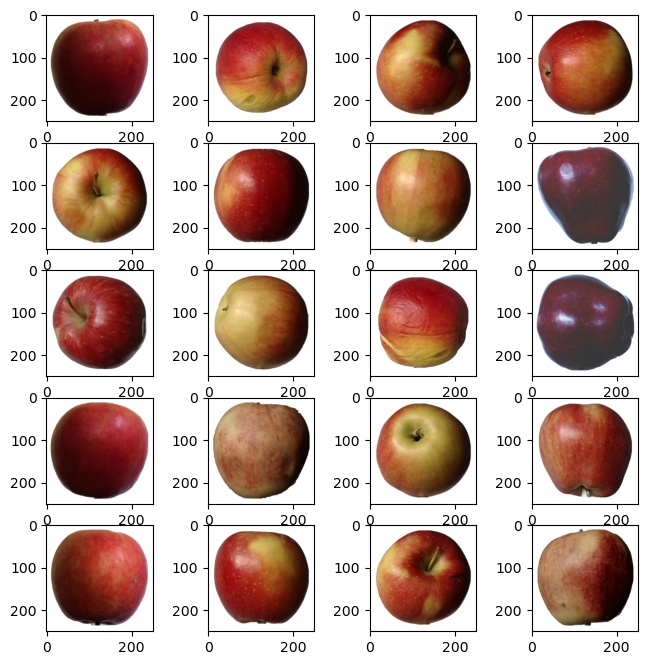

In [29]:
# debug 
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    loc = np.random.randint(1, len(img_data_array_1_class),1 )
    img= img_data_array_1_class[loc[0]]  # 1 class pictures , sampled randomly
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

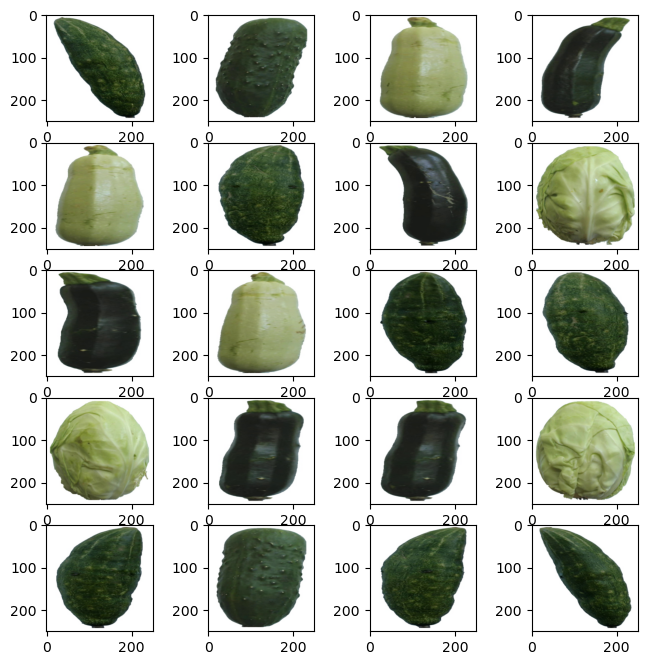

In [30]:
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    loc = np.random.randint(1, len(img_data_array_0_class),1 )
    img= img_data_array_0_class[loc[0]]  #  1 class pictures , sampled randomly
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [91]:
########## Generate "picture blending" for backgroud
### We would train models with pictures with white background
### being unrealistic in real circumstances , we well as 
### generate synthetic ( augmented data ) to be as close as possible to 
### realistic diverse and representative input

In [31]:
## Uplaod pictures on nature scenery

folder_train = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\1_Raw_Data_Train_Test\forest_train_test"

img_data_array_backgroud=[] # store pixels 

for dir1 in os.listdir(folder_train): # loop through files in each folder
    
        image_path= os.path.join(folder_train, dir1)
        
        image= cv2.imread( image_path, cv2.IMREAD_COLOR) # import pixels of picture
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB
             
        image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), # make all pictures standard
                         interpolation = cv2.INTER_AREA)
       
        img_data_array_backgroud.append(image) # append each picture to single structure
       

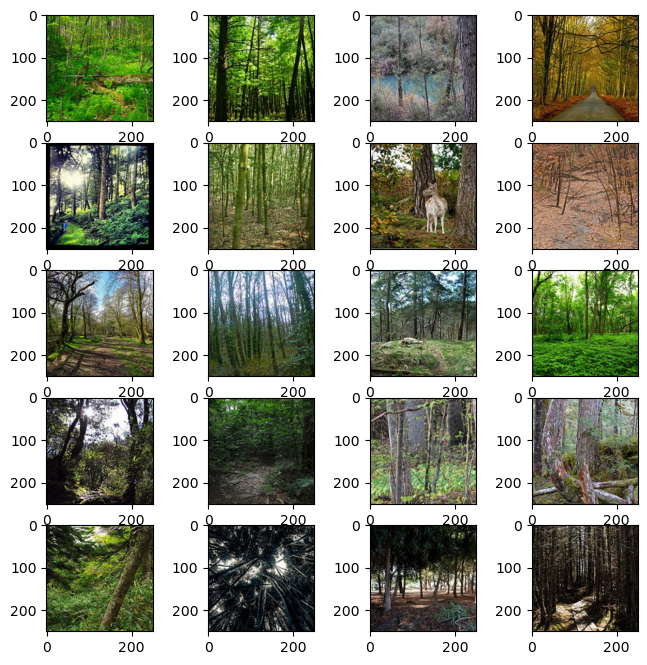

In [32]:
# debug
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    loc = np.random.randint(1, len(img_data_array_backgroud),1 )
    img= img_data_array_backgroud[loc[0]]  # debug
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

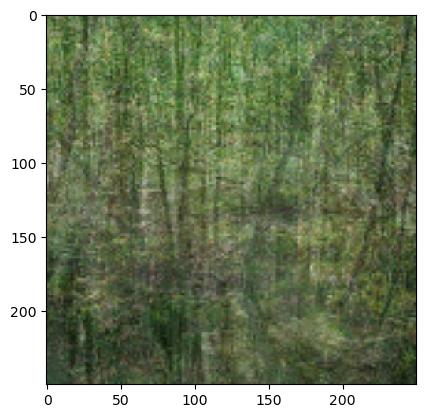

In [45]:
#### Sample of blended backgroupd
#### We generate picture which would substitute
#### white backgound

loc = np.random.randint(1, len(img_data_array_backgroud) ,5 )
equal_fraction = 1 / 5
output = np.zeros_like( img_data_array_backgroud[0] )

list_images = [ img_data_array_backgroud[loc[0]] , 
                img_data_array_backgroud[loc[1]] ,
                img_data_array_backgroud[loc[2]]  ,
                img_data_array_backgroud[loc[3]] ,
                img_data_array_backgroud[loc[4]] ]

for img in list_images:
    output = output + img * equal_fraction
    
output = output.astype(np.uint8)    

plt.imshow(output)

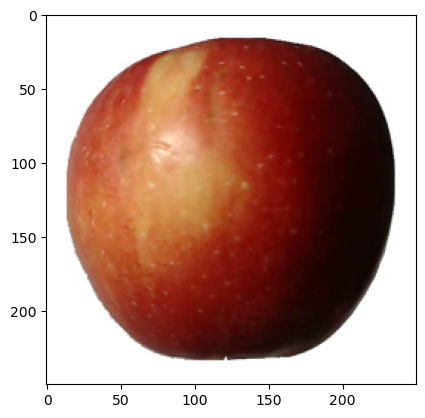

In [46]:
### verify preprocessing with 1 example
apple = img_data_array_1_class[0] 
plt.imshow( img_data_array_1_class[0] ) # debug

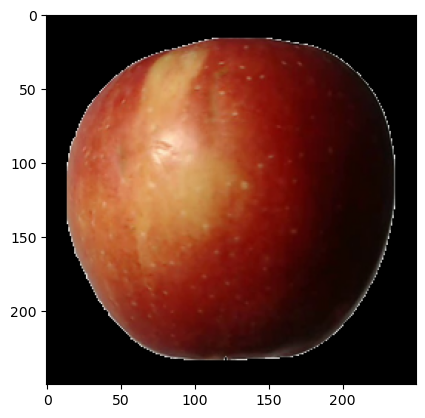

In [47]:
## each picture consist of 3 dimensions, Red , Blue and Green
## we create filter to assign  0 for each value within 3 dimensions
## which is over 230 ( white colour )

white_filter = (apple[:,:,0] > 230) & (apple[:,:,1] > 230) & (apple[:,:,2] > 230)

masked_image = np.copy(apple)
masked_image[white_filter != 0] = [0, 0, 0]
plt.imshow(masked_image)

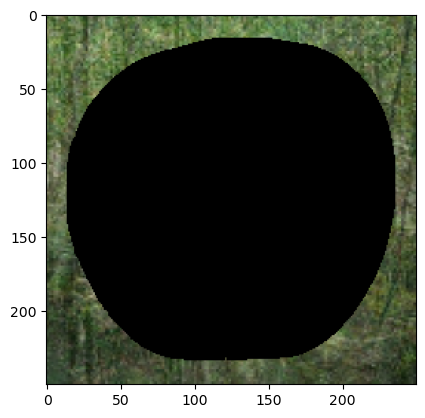

In [48]:
background_image = output.copy()
background_image[~(white_filter)] = [0,0,0]
plt.imshow(background_image)

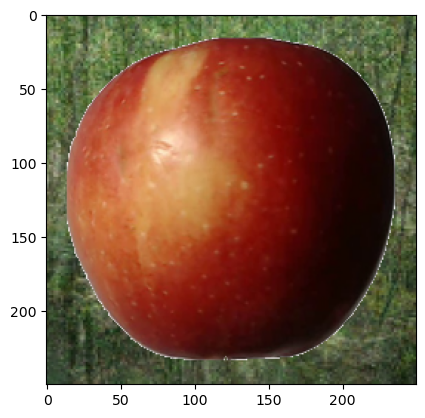

In [49]:
## replace white background
complete_image = masked_image + background_image
plt.imshow(complete_image)

In [50]:
####### Now  export 1 class pictures and store
###### pics with white and blended background 
###### We expect to train the model pattern in which 
###### background of object can be different while
###### the target area is characterised by presence of Red and Round Object

path_export = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\2_Train_Test_Augmented_1_class"

for i in range( 0  ,  len(img_data_array_1_class) ) :  # len(img_data_array_1_class)

    ## generate backgroud
            loc = np.random.randint(1, len(img_data_array_backgroud) ,4 )
           # print( loc )  locations are random
            equal_fraction = 1 / 4
            background = np.zeros_like( img_data_array_backgroud[0] )
            list_images = [ img_data_array_backgroud[loc[0]] , 
                            img_data_array_backgroud[loc[1]] ,
                            img_data_array_backgroud[loc[2]]  ,
                            img_data_array_backgroud[loc[3]] ]

            for img in list_images:
                background = background + img * equal_fraction

            background = background.astype(np.uint8) ## cv2 visualise matrices of integers   
      
     ## sequentially process pictures with target
            apple = img_data_array_1_class[i] 
            
            white_filter = (apple[:,:,0] > 230) & (apple[:,:,1] > 230) & (apple[:,:,2] > 230)
            
            masked_image = apple.copy()          
            masked_image[white_filter != 0] = [0, 0, 0]
            
            background[~(white_filter)] = [0,0,0]
            
     ## form final image with new background and export it
    
            complete_image = masked_image + background
        
            complete_image = cv2.cvtColor(complete_image, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB
            
            path_export_full = os.path.join ( path_export , "picture_"+str(i)+".jpg" )    
            cv2.imwrite(path_export_full, complete_image )
    
     ## export original picture with white background
    
            apple = cv2.cvtColor(apple, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB
            path_export_full = os.path.join ( path_export , "picture_orig"+str(i)+".jpg" )          
            cv2.imwrite(path_export_full, apple )
            
            
y_count = len( img_data_array_1_class )  * 2          

In [51]:
[y_count , complete_image.shape]

[6460, (250, 250, 3)]

In [52]:
################ Now generate Train data for 0 class, 
## By cutting piece of picture and adding blended background 
# We slice the picture into 9 parts and selection random one

height = int( IMG_HEIGHT / 3 ) # ( 3 * 3 = 9 pics )
width = int( IMG_WIDTH / 3 )
height,width # debug

(83, 83)

In [53]:
#### We would create coordinates for each piece out of 9 and would sample 
#### 1 sub pic from each downloaded picture of apple
x_start = np.arange( start = 0 , stop = IMG_HEIGHT -  width , step = width)
y_start = x_start.copy()

In [54]:
#### Reupload data and sample 1 sub image from each photo of target class
folder_train = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\2_Train_Test_Augmented_1_class"
# os.listdir( folder_train )

In [55]:
img_data_array_gen_pics=[] # store pixels 

for dir1 in os.listdir ( folder_train ):
         
        image_path= os.path.join(folder_train, dir1)

        image= cv2.imread( image_path, cv2.IMREAD_COLOR) # import pixels of picture
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB
        
        image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), # make all pictures standard
                         interpolation = cv2.INTER_AREA)
           
        ## set coordinates for sub pic (proposal)    
        random_coordinates = np.random.randint(low=0 , high=3, size = 2)
        loc_x = random_coordinates[0]
        loc_y = random_coordinates[1]

        timage =  image[ x_start[loc_x]:(x_start[loc_x]+width) , y_start[loc_y]:(y_start[loc_y]+height) ]
        
        timage = cv2.resize(timage, (IMG_HEIGHT, IMG_WIDTH), # make all pictures standard
                                 interpolation = cv2.INTER_AREA)
        # plt.imshow(buf_del )
        
       
        img_data_array_gen_pics.append(timage) # append each picture to single structure
 

In [56]:
len(img_data_array_gen_pics) == y_count     # debug

True

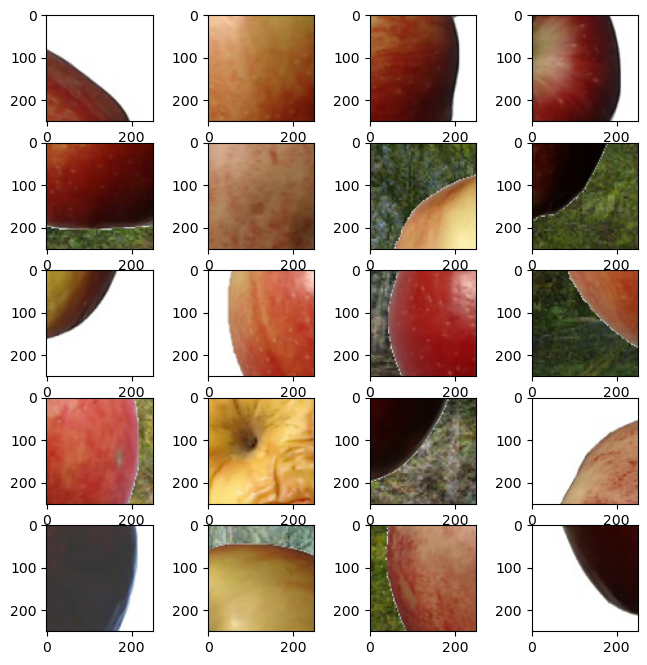

In [57]:
# debug
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    loc = np.random.randint(1, len(img_data_array_gen_pics),1 )
    img= img_data_array_gen_pics[loc[0]]  # debug
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [58]:
########## Export Augmented photos treated as 0 class

path_export = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\3_Train_Test_Augmented_0_class"

for i in range( 0  ,  len(img_data_array_gen_pics) ) :  # len(img_data_array_1_class)

            complete_image = img_data_array_gen_pics[i]
        
            complete_image = cv2.cvtColor(complete_image, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB
            
            path_export_full = os.path.join ( path_export , "picture_"+str(i)+".jpg" )
            
            cv2.imwrite(path_export_full, complete_image )

In [59]:
########## Export  0 class photos of Original size , with white and blended background

for i in range( 0  ,  len(img_data_array_0_class) ) :  # len(img_data_array_1_class)

    ## generate backgroud
            loc = np.random.randint(1, len(img_data_array_backgroud) ,4 )
           # print( loc )  locations are random
            equal_fraction = 1 / 4
            background = np.zeros_like( img_data_array_backgroud[0] )
            list_images = [ img_data_array_backgroud[loc[0]] , 
                            img_data_array_backgroud[loc[1]] ,
                            img_data_array_backgroud[loc[2]]  ,
                            img_data_array_backgroud[loc[3]] ]

            for img in list_images:
                background = background + img * equal_fraction

            background = background.astype(np.uint8) ## cv2 visualise matrices of integers   
      
     ## sequentially process pictures with target
            other = img_data_array_0_class[i] 
            
            white_filter = (other[:,:,0] > 230) & (other[:,:,1] > 230) & (other[:,:,2] > 230)
            
            masked_image = other.copy()          
            masked_image[white_filter != 0] = [0, 0, 0]
            
            background[~(white_filter)] = [0,0,0]
            

    
    ## export 0 class with blended background
            complete_image = masked_image + background      
            complete_image = cv2.cvtColor(complete_image, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB
            
            path_export_full = os.path.join ( path_export , "picture_other"+str(i)+".jpg" )           
            cv2.imwrite(path_export_full, complete_image )
            
    ## export 0 class with original  white         
            other = cv2.cvtColor(other, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB
            path_export_full = os.path.join ( path_export , "picture_orig"+str(i)+".jpg" )          
            cv2.imwrite(path_export_full, other )
            
              

In [25]:
img_data_array_0_class[0].size

187500

In [60]:
######### Export Non Augmented 0 class stored in img_data_array_backgroud

path_export = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\4_Train_Test_NON_Augmented_0_class"

for i in range( 0  ,  len(img_data_array_backgroud) ) :  # len(img_data_array_1_class)

            complete_image = img_data_array_backgroud[i]
        
            complete_image = cv2.cvtColor(complete_image, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB
            
            path_export_full = os.path.join ( path_export , "picture_nature"+str(i)+".jpg" )
            
            cv2.imwrite(path_export_full, complete_image )